Notebook for Plotting d18O data. It includes:
 - Loading the raw d18O data
 - Loading the age-sediment depth model files
 - Load the list of which cores are associated with which stack
 - Load the core locations information (lat,lon,dep,basin)
 - Match the d18O data to their age models to get an age-d18O dataframe
 - For each stack, plot the d18O data with age

# File Set up

In [1]:
# Import the required packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import scipy.interpolate as interpolate
import itertools
from matplotlib import gridspec

In [2]:
# Define variables to use throughout the notebook
fontsize = 22

# Importing data

## Import d18O data

In [3]:
# Create empty dictionary for the raw d18O dataframes to be stored in
d18O_raw_dict = {}

# Loop over every file in the d18O folder
for d18O_file in glob.glob('/srv/ccrc/data06/z5145948/d18o_species_corrected/Raw_data/*'):
    
    # Read in the file as pandas dataframe
    df_d180 = pd.read_csv(d18O_file,delimiter='\t',header=None).rename(columns={0:'sed_dep',1:'d18O'})
    
    # Get the core name
    core_name = d18O_file.split('/')[-1].split('_')[0]
    
    # Store loaded dataframe in a dictionary
    d18O_raw_dict.update({
        core_name:df_d180
    })

## Import age models

In [4]:
# get a list of strings of all files in the folder that contains the age model files. Needs to be sorted
all_files = glob.glob('/srv/ccrc/data06/z5145948/Core_files/Saved_data/Holocene/*')

# Refine the list of all the files to just be a list of the age models
age_model_files = list(filter(lambda k: '_ageLS16' in k, all_files))

# Create empty dictionary for the age model dataframes to be stored in
age_dict = {}

# Loop over the age model files in the list
for age_model_file in age_model_files:

    # Read each age model file
    # Note this delimiter won't work, because the columns are separated by an inconsistent number of spaces
    df_age = pd.read_csv(age_model_files[0],delimiter='\t',header=None)

    # Split the columns into sediments and age
    df_age = pd.DataFrame([[x.lstrip().rstrip().split(' ')[0],
                   x.lstrip().rstrip().split(' ')[-1]] for x in df_age[0]]).rename(
                                                                             columns={0:'sed_dep',1:'age'})
    # Convert values to float
    df_age = df_age.astype(float)
    
    # Get the core name
    core_name = age_model_file.split('/')[-1].split('_')[0]

    # Store loaded dataframe in a dictionary
    age_dict.update({
        core_name:df_age
    })


## Import core locations

In [5]:
# Get location data for the atlantic ocean cores
df_locs_atl = pd.read_csv(
    '/srv/ccrc/data06/z5145948/Core_files/Saved_data/Holocene/atl_core_data_LS16.txt',
    header=None).rename(columns={0:'Core',1:'Basin',2:'Lat',3:'Lon',4:'Ocean_depth'})

# Get location data for the indian and pacific oceans cores
df_locs_ind_pac = pd.read_csv(
    '/srv/ccrc/data06/z5145948/Core_files/Saved_data/Holocene/indopac_core_data_LS16.txt',
    header=None).rename(columns={0:'Core',1:'Basin',2:'Lat',3:'Lon',4:'Ocean_depth'})

# Combine both location dataframes
df_locs = df_locs_ind_pac.append(df_locs_atl)


## Import Core Stack Information

In [6]:
# Create an empty dictionary with all cores and what stack they are associated with
stack_dict = {}

# Create an empty list to fill with the different stack names
stack_names_list = []

# Loop over all the stack files (one file per stack, containing a list of cores)
for stack_path in glob.glob('/srv/ccrc/data06/z5145948/d18o_species_corrected/Stacks/*'):

    # Read in list of cores as dataframe
    df_stack = pd.read_csv(stack_path,header=None).rename(columns={0:'Core'})
    
    # get the name of the stack used by stern and lisieck 2016
    stack_name = stack_path.split('/')[-1].split('.')[0]
    
    # For each core, update dictionary with the stack name
    for core in df_stack['Core']:
        stack_dict.update({
            core:stack_name
        })
        
    # Put the stack names into a list
    stack_names_list.append(stack_name)

# Matching d18O to age

Currently it doesn't match all the cores. It only blindly tries to match the keys of the two dictionaries together.
I might need to make it work so that all d18O age model can be accounted for

In [7]:

# Create empty dictionary for the d18O data with the interpolated age model dataframes to be stored in
age_d18O_dict = {}

# Loop over all the age models
for core in age_dict:
    
    # Use a try to skip this core if there is no corresponding d18O key in the dictionary of dataframes
    # it only works for about 100 cores right now.... (out of ~260)
    try:
        d18O_raw_dict[core]
    except KeyError:
        continue
    
    # Create interpolation function on the age model dataframe
    age_interp_func = interpolate.interp1d(age_dict[core]['sed_dep'],age_dict[core]['age'],
                                          bounds_error=False,fill_value=np.nan)

    # Interpolate the ages to the d18O sediment depths
    age_interpolated = age_interp_func(list(d18O_raw_dict[core]['sed_dep']))

    df_age_d18O = pd.DataFrame.from_dict({'age':age_interpolated,'d18O':d18O_raw_dict[core]['d18O']})

    age_d18O_dict.update({
        core:df_age_d18O
    })


/srv/ccrc/data06/z5145948/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/srv/ccrc/data06/z5145948/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


# Plotting age-d18O

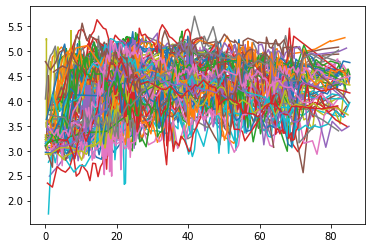

In [8]:
# Start off by just plotting all of the data
for core in age_d18O_dict:
    plt.plot(age_d18O_dict[core]['age'],
             age_d18O_dict[core]['d18O'])

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


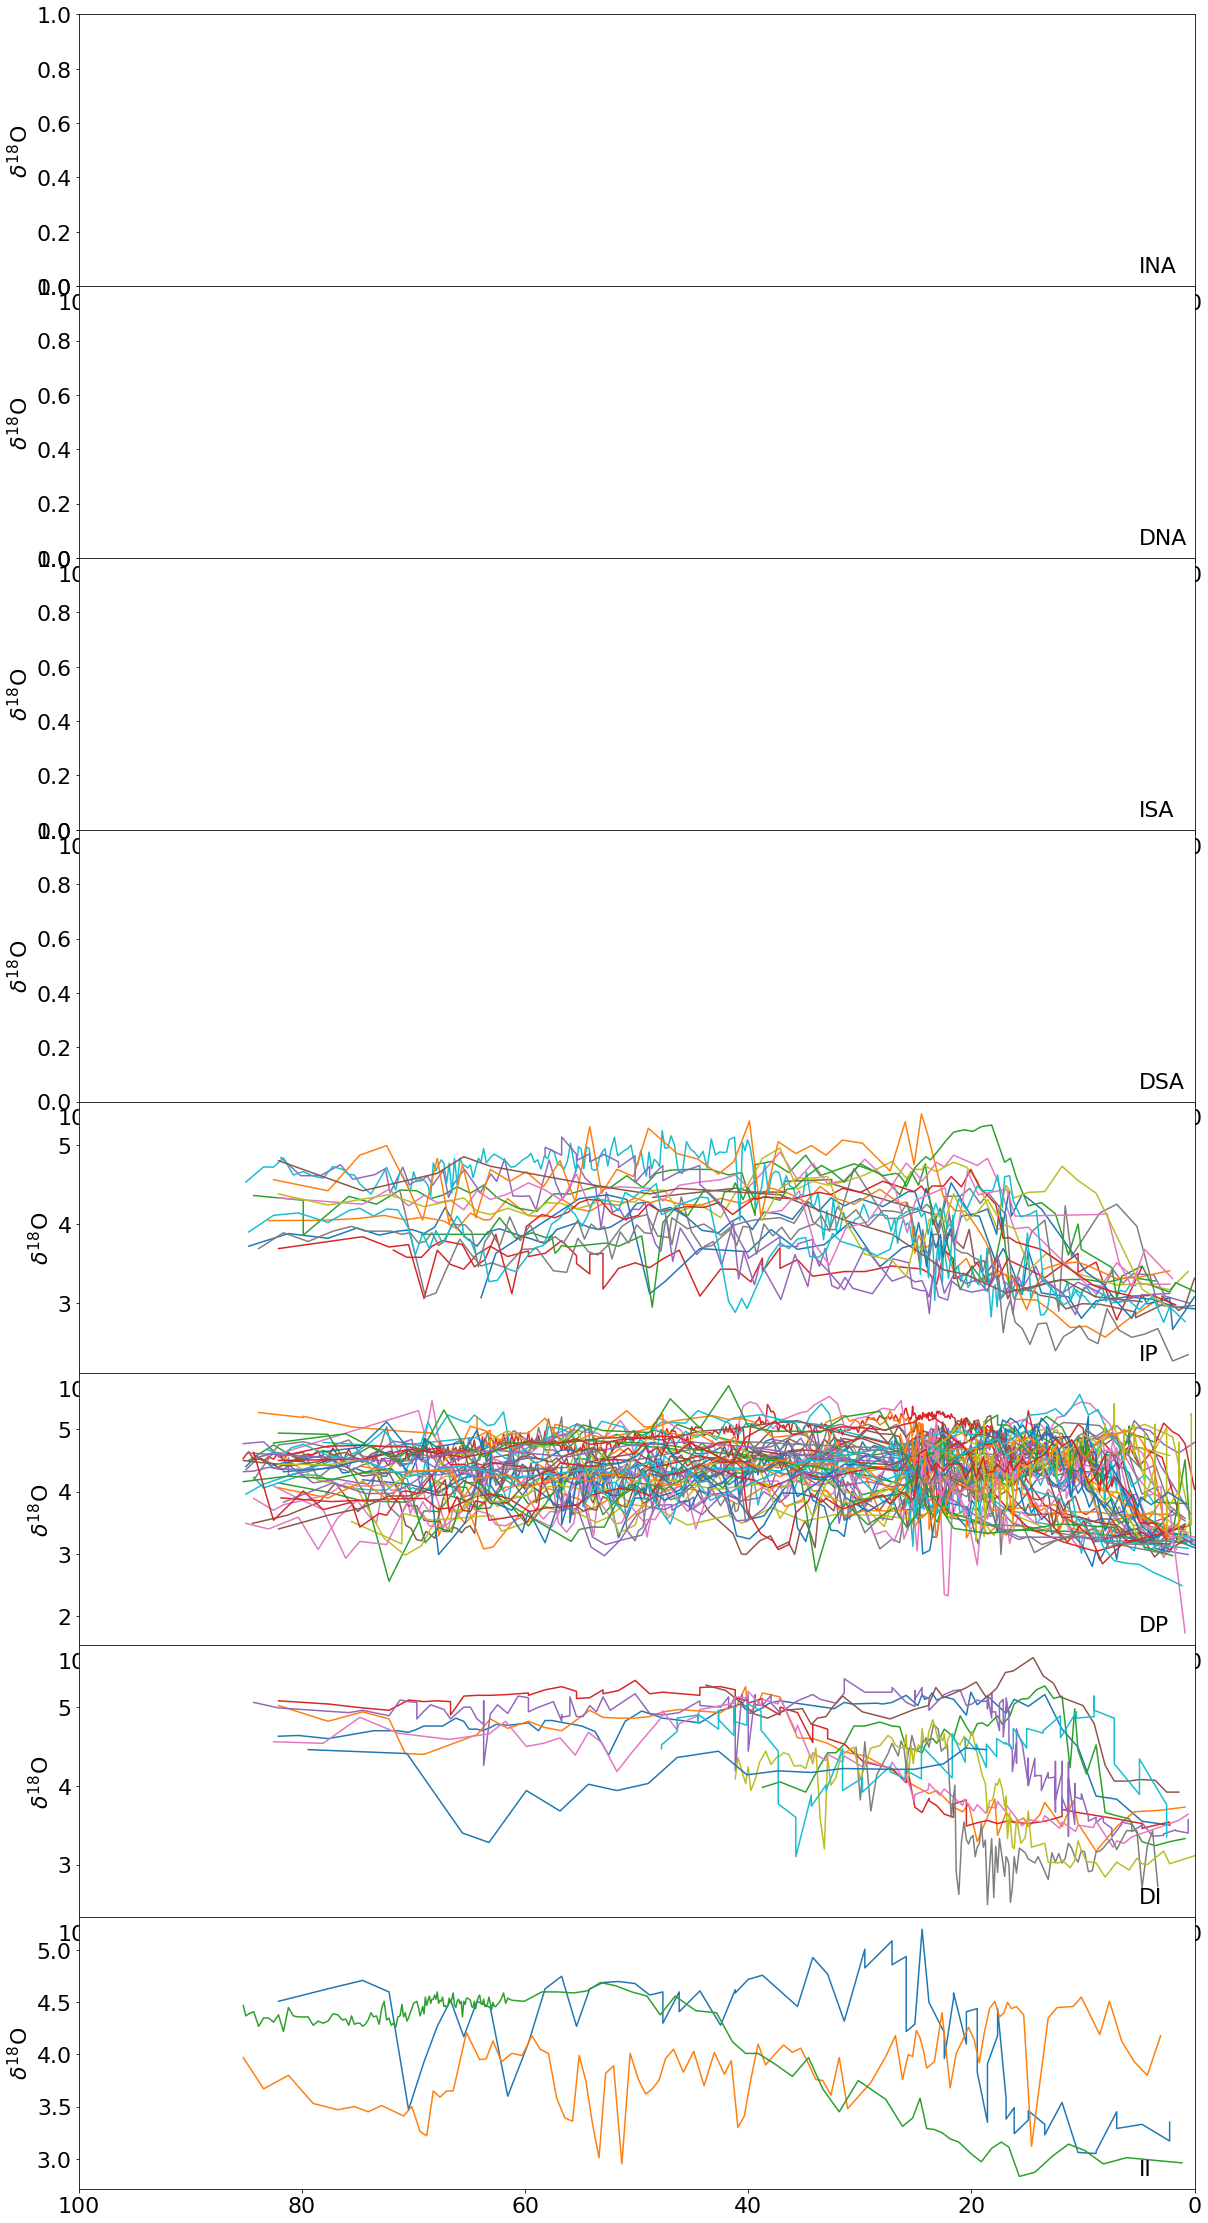

In [9]:
# Set the Figure size
fig = plt.figure(figsize=(20,40))

# Set figure text appearance
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}
matplotlib.rc('font', **font)

# set up the number of subplots--one for each axes
gs = gridspec.GridSpec(len(stack_names_list),ncols=1)

# Loop over the list of stack names and use a counter for the axes (axc) 
for stack,axc in zip(stack_names_list,np.arange(0,len(stack_names_list),1)):
    
    # Get the relevant axes
    ax = plt.subplot(gs[axc])
    
    # Looping over keys (k) and values (v), make a dict of only the cores for this stack
    region_stack_dict = {k:v for k,v in stack_dict.items() if v==stack}
    
    # Get a list of all the cores for which we have d18O data and a regional alignment;
        # i.e. finding the intersection
    region_cores = set(age_d18O_dict.keys()).intersection(set(region_stack_dict.keys()))
    
    # Plot each of the cores in the set of cores that has been created for a given stack
    for core in region_cores:
        ax.plot(age_d18O_dict[core]['age'],
                age_d18O_dict[core]['d18O'])
        
    # Set x limits
    ax.set_xlim(100,0)        
        
    # Label each of the subplots with what region it is
    ax.text(ax.get_xlim()[1]-0.05*np.diff(ax.get_xlim()),
            ax.get_ylim()[0]+0.05*np.diff(ax.get_ylim()),
            stack)
    
    # Label axes
    ax.set_ylabel('$\delta^{18}$O')
    
    # Turn off x axis if it's not the last plot. If it is, label it
#     if axc!=(axc-1):
#         ax.set_xticks([])
#     else:
#         ax.set_xlabel('Time (ka BP)')

# Plot the graph

plt.subplots_adjust(wspace=0,hspace=0)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}
matplotlib.rc('font', **font)

plt.show()